In [94]:

import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import transform
from scipy import signal
from scipy import ndimage


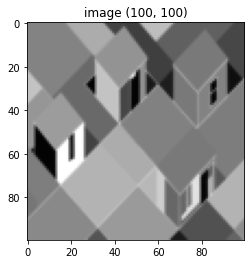

In [98]:
# Read image
img = io.imread("imgs/houses.png")
img = np.sum(img, axis=2)
img = img / np.max(img)

img = transform.resize(img, (100, 100))

# noise = np.random.normal(0.01, 0.01, img.shape)
# img = img + noise

plt.figure()
plt.title(f"image {img.shape}")
plt.imshow(img, cmap='gray')


# Bayesian classification

## The principle

### Bayesian statistic :

The **Evidence** $p(x)$ is usually an observation of $X$.

The **Prior** $p(\theta)$ is a global knowledge of $\Theta$ independantly of $X$.

The **Likelyhood** $p(x|\theta)$ comes from the knowledge of the $x$ that are part of $\theta$.

The **Posterior** $p(\theta|x)$ is the outcome of $\theta$ for an observation $x$.

$\boxed{
Posterior = \frac{Likelihood \quad Prior}{Evidence}
}$

$\boxed{
p(\theta|x) = \frac{p(x|\theta) p(\theta)}{p(x)}
}$


### Application to image classification

We model the image as follow:

* $\Omega = {w_1, w_2, w_3, ...}$ the set of classes.
* $S = \{s\} $ the set of pixels.
* $y_s$ the gray level of pixel $s$.
* $Y_s$ the random variable associated with the pixel s.

We observe the **Evidence** $P(y_s)$ over $S$ which is the appearance frequencies of each gray level $y_s$.

We might have a **Prior** $P(w_i)$ which is the appearance frequencies of each class $w_i$ in the image that can be **learned from images classifications** or **modeled**.

We might also have a **Likelyhood** $P(y_s|w_i)$ which tells what are the gray levels associated with each classes and can be **learned from images classifications** or **modeled**.


We want to choose for each pixel y_s a class w_s such that the **Posterior** $P(w_i|y_s)$ is maximized.

$\boxed{
p(w_i|y_s) = \frac{p(y_s|w_i) p(w_i)}{p(y_s)}
}$

**NB:** if the classes are uniformly distributed ($p(w_i)$ is uniform), the in becomes a **Likelyhood maximization**.


## Classification by histogram modes

Here we assume that the classes are uniformly distributed. So do a **Likelyhood maximization**.

From the assumption that object of the same classe have very similar color, and the main classes have the most common colors in the image.

We associate each mode (local maximum) in the image histogram to each class. So each local maximum in the histogram will be a class.

We can then evaluate the **Likelyhood** $p(y_s|w_i)$ by measuring the distance from the color values of the maxima of the histogram associated with the class $w_i$ and the color value $y_s$ of the pixel. the smaller that distance, the higher is $p(y_s|w_i)$.

**Noise:** We can apply a gaussian filter to the histogram to reduce any eventual noise.

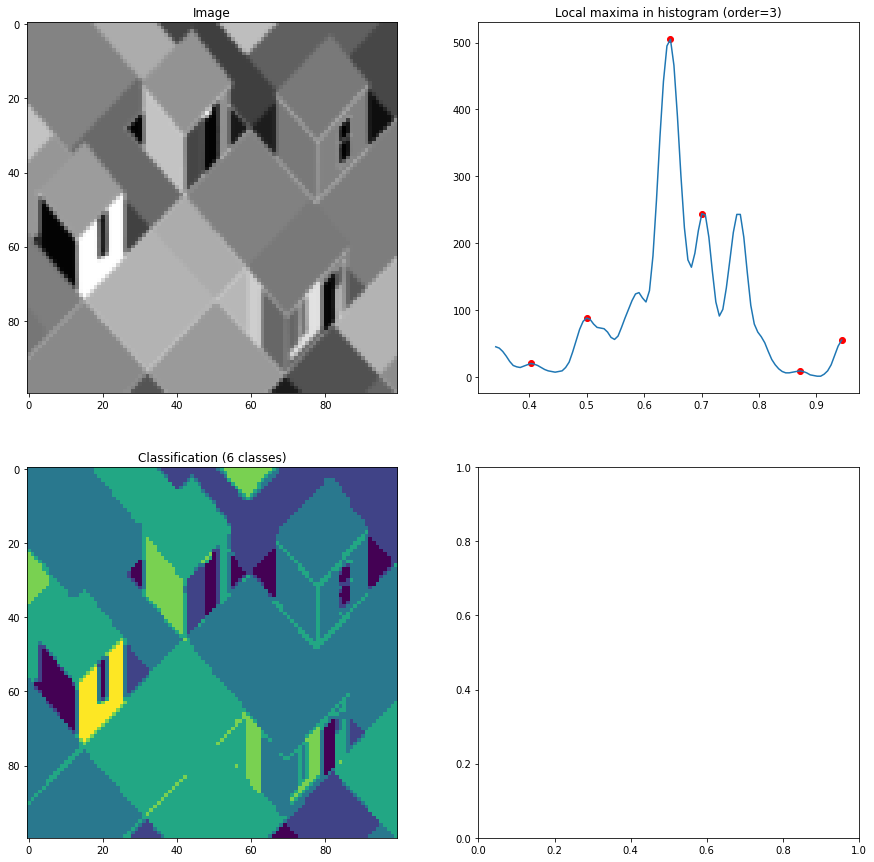

In [109]:
gauss_var = 0.1
img_filtered = ndimage.gaussian_filter(img, sigma=gauss_var)

# Compute image histogram
hist, bins = np.histogram(img_filtered, bins=100)
bins = bins[:len(bins)-1]

# Filter the histogram with a gaussian to remove noise
hist = ndimage.gaussian_filter(hist, sigma=2)

# Find local maxima in histogram
order = 3
hist_extrema_ind = signal.argrelmax(hist, order=order, mode='wrap')
hist_extrema_val = hist[hist_extrema_ind]
hist_maxima_ind_val = bins[hist_extrema_ind] # color values of the maxima

# Classification by histogram maxima
classes = np.zeros(img_filtered.shape)
for l in range(img_filtered.shape[0]):
  for c in range(img_filtered.shape[1]):
    # For each pixel, find the maxima with the closest color value
    dist_to_maxima = np.abs(hist_maxima_ind_val-img_filtered[l,c])
    maxima_ind = np.argmin(dist_to_maxima)
    classes[l,c] = maxima_ind

fig, axisarray = plt.subplots(2, 2, figsize=(15,15))
# Image
axisarray[0,0].set_title('Image')
axisarray[0,0].imshow(img_filtered, cmap='gray')
# Histogram with local maxima
axisarray[0,1].set_title(f"Local maxima in histogram (order={order})")
axisarray[0,1].plot(bins, hist)
axisarray[0,1].scatter(bins[hist_extrema_ind], hist_extrema_val, color='r')
# Classes
axisarray[1,0].set_title(f"Classification ({len(hist_extrema_val)} classes)")
axisarray[1,0].imshow(classes)


## Fingerprint (based on histogram modes)

# K-means classification
